In [1]:
#!pip install tf-keras
#!pip install scikit-learn

In [2]:
import os
import shutil
from IPython.display import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np
sys.path.append('aux_scripts.py')

i = "3classes_better_wrong"
image_size = 299

2025-01-24 17:11:48.271216: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-24 17:11:48.393833: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-24 17:11:48.510055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737735108.618787    4205 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737735108.653688    4205 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 17:11:48.925481: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## NN creation and training

### Split the data into training and validation sets

In [6]:
# Function to clear a directory
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove the directory and its contents
    os.makedirs(directory, exist_ok=True)  # Recreate an empty directory

# Function to copy files to target directories
def copy_files(file_list, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for file in file_list:
        shutil.copy(file, target_dir)

# Function to split dataset
def split_dataset(source_dir, test_size=0.2):
    files = os.listdir(source_dir)
    files = [os.path.join(source_dir, f) for f in files]
    train_files, temp_files = train_test_split(files, test_size=test_size, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
    return train_files, val_files, test_files

# Split the dataset
def split_and_copy(train_dir, val_dir, test_dir):

    # Clear the train, val, and test directories before splitting
    clear_directory(train_dir)
    clear_directory(val_dir)
    clear_directory(test_dir)

    mask_train_files, mask_val_files, mask_test_files = split_dataset(mask_dir)
    no_mask_train_files, no_mask_val_files, no_mask_test_files = split_dataset(no_mask_dir)
    wrong_mask_train_files, wrong_mask_val_files, wrong_mask_test_files = split_dataset(wrong_mask_dir)

    # Copy files to train/val/test directories
    copy_files(mask_train_files, os.path.join(train_dir, 'mask'))
    copy_files(mask_val_files, os.path.join(val_dir, 'mask'))
    copy_files(mask_test_files, os.path.join(test_dir, 'mask'))

    copy_files(no_mask_train_files, os.path.join(train_dir, 'no_mask'))
    copy_files(no_mask_val_files, os.path.join(val_dir, 'no_mask'))
    copy_files(no_mask_test_files, os.path.join(test_dir, 'no_mask'))
    
    copy_files(wrong_mask_train_files, os.path.join(train_dir, 'wrong_mask'))
    copy_files(wrong_mask_val_files, os.path.join(val_dir, 'wrong_mask'))
    copy_files(wrong_mask_test_files, os.path.join(test_dir, 'wrong_mask'))

In [7]:
# Paths to directories
dataset_dir = '../dataset'
train_dir = '../dataset_split/train'
val_dir = '../dataset_split/val'
test_dir = '../dataset_split/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

mask_dir = os.path.join(dataset_dir, 'mask')
no_mask_dir = os.path.join(dataset_dir, 'no_mask')
wrong_mask_dir = os.path.join(dataset_dir, 'wrong_mask')

split_and_copy(train_dir, val_dir, test_dir)

# Data augmentation and generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(image_size, image_size), batch_size=32, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir, target_size=(image_size, image_size), batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(image_size, image_size), batch_size=32, class_mode='categorical', shuffle=False)

Found 3650 images belonging to 3 classes.
Found 456 images belonging to 3 classes.
Found 458 images belonging to 3 classes.


In [4]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 200 

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True  # Restore the weights of the best epoch
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Reduce learning rate when validation loss plateaus
    factor=0.2,          # Reduce learning rate by a factor of 5
    patience=5,          # Wait 5 epochs before reducing
    min_lr=1e-6          # Set a floor for the learning rate
)

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks= [early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model.save(f'mask_detector_model_{i}.h5')

# Print training summary
print("Model trained and saved as 'mask_detector_model.h5'")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 3650 images belonging to 3 classes.
Found 456 images belonging to 3 classes.
Found 458 images belonging to 3 classes.


/tmp/ipykernel_30162/4171927727.py:34: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
W0000 00:00:1736776059.526007   30162 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/andre/Documents/Image-and-Speech-Recognition-Project/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_s

Epoch 1/200


2025-01-13 14:47:46.868983: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 276480000 exceeds 10% of free system memory.
2025-01-13 14:47:47.074530: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 280178688 exceeds 10% of free system memory.


  1/115 ━━━━━━━━━━━━━━━━━━━━ 11:06 6s/step - accuracy: 0.3125 - loss: 1.5720

2025-01-13 14:47:48.339203: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 276480000 exceeds 10% of free system memory.
2025-01-13 14:47:48.542821: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 280178688 exceeds 10% of free system memory.


  2/115 ━━━━━━━━━━━━━━━━━━━━ 2:46 1s/step - accuracy: 0.3359 - loss: 1.5125 

2025-01-13 14:47:49.794637: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 276480000 exceeds 10% of free system memory.


115/115 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.8096 - loss: 0.4975 - val_accuracy: 0.9518 - val_loss: 0.1432 - learning_rate: 0.0010
Epoch 2/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9468 - loss: 0.1525 - val_accuracy: 0.9452 - val_loss: 0.1287 - learning_rate: 0.0010
Epoch 3/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.9488 - loss: 0.1435 - val_accuracy: 0.9605 - val_loss: 0.1010 - learning_rate: 0.0010
Epoch 4/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.9585 - loss: 0.1209 - val_accuracy: 0.9561 - val_loss: 0.1393 - learning_rate: 0.0010
Epoch 5/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9718 - loss: 0.0905 - val_accuracy: 0.9715 - val_loss: 0.0883 - learning_rate: 0.0010
Epoch 6/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.9688 - loss: 0.0938 - val_accuracy: 0.9539 - val_loss: 0.1202 - learning_rate: 0.0010
Epoch 7/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.9751 - loss: 0.0764 

Test Loss: 0.08759317547082901
Test Accuracy: 0.9737991094589233
Model trained and saved as 'mask_detector_model.h5'
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9789 - loss: 0.0826
Test Loss: 0.08759317547082901
Test Accuracy: 0.9737991094589233


### Test the model on the test set

Load the model

In [8]:
## load the model
model = tf.keras.models.load_model(f'mask_detector_model_{i}.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,341 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

## F1-Score and Confusion matrix

/home/andre/Documents/Image-and-Speech-Recognition-Project/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-01-24 17:13:15.288507: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34329984 exceeds 10% of free system memory.
2025-01-24 17:13:15.605520: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34329984 exceeds 10% of free system memory.
2025-01-24 17:13:16.642529: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.
2025-01-24 17:13:16.770973: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 excee

15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step
Classification Report:
              precision    recall  f1-score   support

        mask       0.98      0.98      0.98       196
     no_mask       0.97      0.98      0.98       193
  wrong_mask       0.97      0.93      0.95        69

    accuracy                           0.97       458
   macro avg       0.97      0.96      0.97       458
weighted avg       0.97      0.97      0.97       458



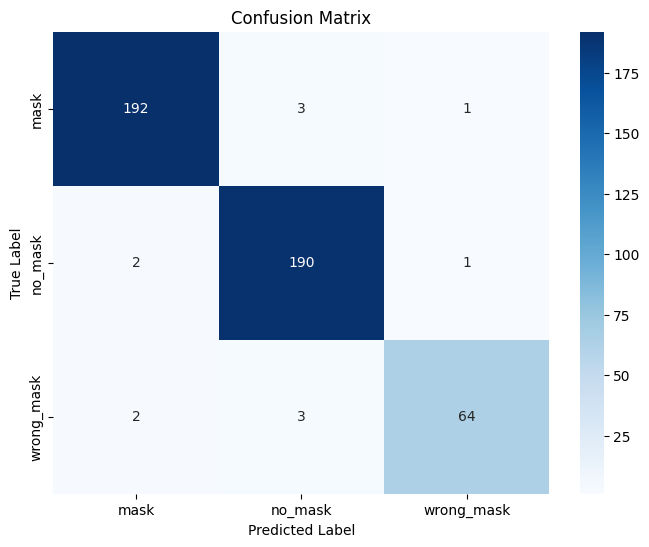

In [9]:
# Get true labels
y_true = test_generator.classes  # True class labels from the test generator

# Get predicted labels
y_pred_probs = model.predict(test_generator)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=-1)     # Convert to class indices

# Class labels (should match the order of your classes in test_generator.class_indices)
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

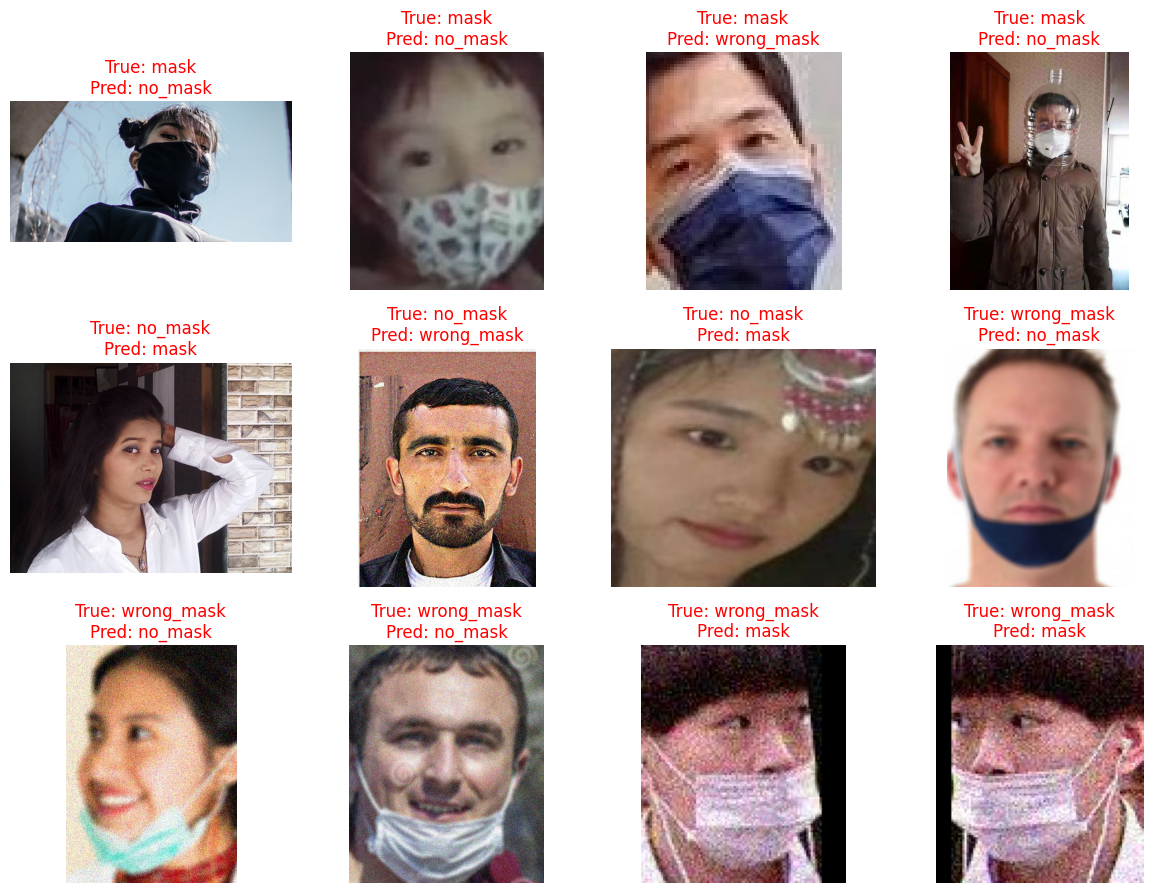

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Find indices of misclassified images
misclassified_indices = np.where(y_true != y_pred)[0]

# Get filepaths of misclassified images
misclassified_filepaths = np.array(test_generator.filepaths)[misclassified_indices]

# True and predicted labels of the misclassified images
misclassified_true_labels = y_true[misclassified_indices]
misclassified_pred_labels = y_pred[misclassified_indices]

# Display the misclassified images
plt.figure(figsize=(12, 12))
for i, filepath in enumerate(misclassified_filepaths[:16]):  # Display up to 16 images
    img = plt.imread(filepath)  # Read the image
    true_label = class_labels[misclassified_true_labels[i]]
    pred_label = class_labels[misclassified_pred_labels[i]]
    
    plt.subplot(4, 4, i + 1)  # Arrange images in a grid
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", color='red' if true_label != pred_label else 'green')
    plt.axis('off')

plt.tight_layout()
plt.show()


Test the model on the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


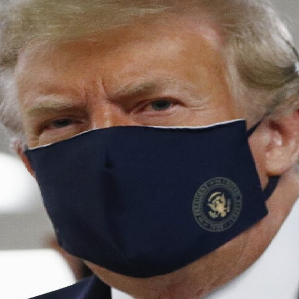

Image: dims.apnews.jpeg_face_1.png - Prediction: Mask (Probabilities: [9.9666303e-01 3.1365323e-06 3.3338261e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


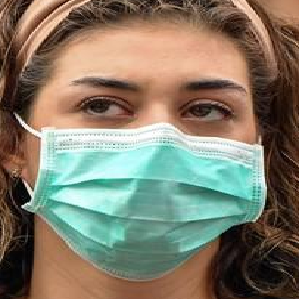

Image: mix_mask_3.jpg_face_1.png - Prediction: Mask (Probabilities: [7.7067411e-01 1.4676091e-05 2.2931120e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


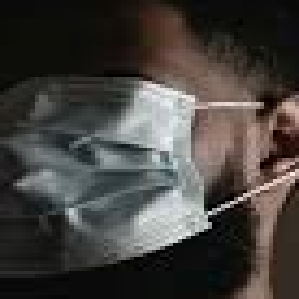

Image: bor_lin2.jpeg_face_1.png - Prediction: Mask (Probabilities: [0.9943679  0.00424451 0.00138763])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


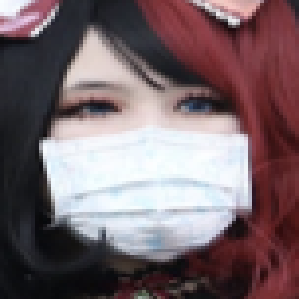

Image: w_mask_2.png_face_2.png - Prediction: Mask (Probabilities: [0.9188909  0.00626753 0.07484157])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


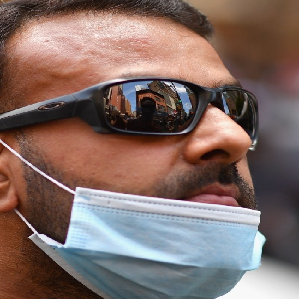

Image: bor_lin14.jpeg_face_1.png - Prediction: Wrong Mask (Probabilities: [7.8289639e-03 2.4173492e-05 9.9214691e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


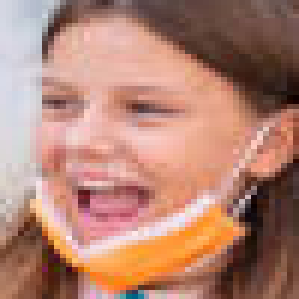

Image: gettyimages-1269940262-612x612.jpg_face_1.png - Prediction: Mask (Probabilities: [0.5231803  0.10346348 0.3733562 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


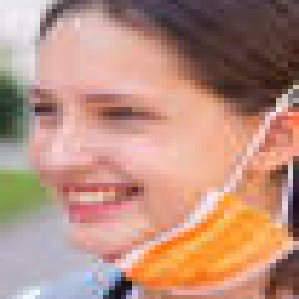

Image: gettyimages-1269940262-612x612.jpg_face_2.png - Prediction: Mask (Probabilities: [0.88864887 0.03731566 0.07403543])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


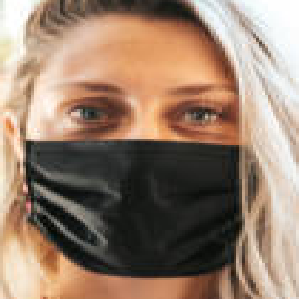

Image: gettyimages-1280412006-612x612.jpg_face_2.png - Prediction: Mask (Probabilities: [0.9216451  0.00191943 0.07643554])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


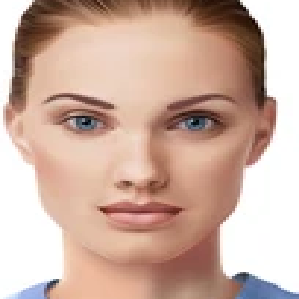

Image: test2.png_face_1.png - Prediction: Mask (Probabilities: [0.9184409  0.06939086 0.01216828])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


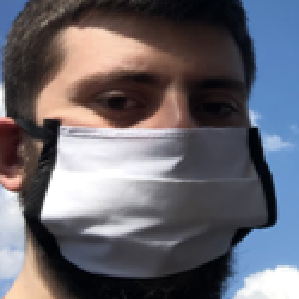

Image: w_mask_1.png_face_1.png - Prediction: Mask (Probabilities: [9.9499810e-01 3.5887869e-04 4.6429625e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


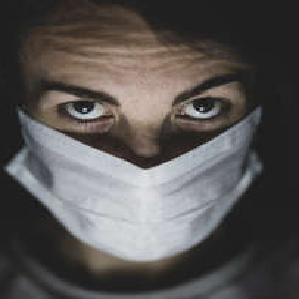

Image: bor_lin5.jpg_face_1.png - Prediction: Mask (Probabilities: [9.7879350e-01 1.0316825e-04 2.1103291e-02])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


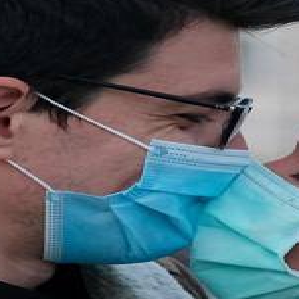

Image: bor_lin6.jpg_face_2.png - Prediction: Mask (Probabilities: [9.1413200e-01 3.9490646e-05 8.5828610e-02])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


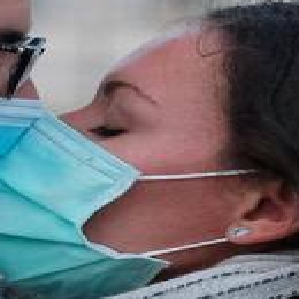

Image: bor_lin6.jpg_face_1.png - Prediction: Mask (Probabilities: [9.9226499e-01 1.3106618e-04 7.6040095e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


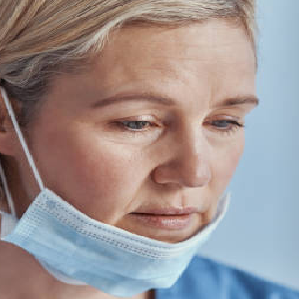

Image: gettyimages-1283003212-612x612.jpg_face_1.png - Prediction: Wrong Mask (Probabilities: [1.3679740e-04 4.9627611e-06 9.9985826e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


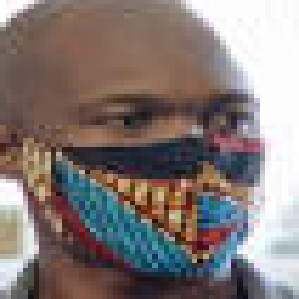

Image: gettyimages-1481643395-612x612.jpg_face_1.png - Prediction: Mask (Probabilities: [9.9928135e-01 4.6663277e-04 2.5202698e-04])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


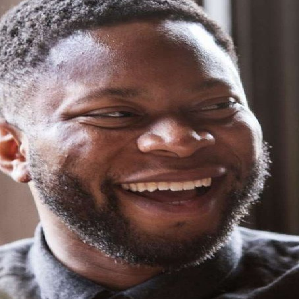

Image: bor_lin10.jpeg_face_1.png - Prediction: No Mask (Probabilities: [3.7782388e-07 6.8707418e-01 3.1292543e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


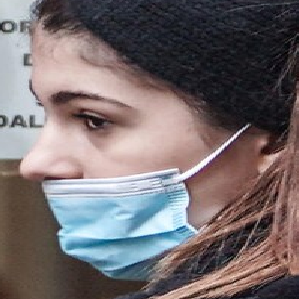

Image: bor_lin7.jpg_face_1.png - Prediction: Wrong Mask (Probabilities: [0.02921245 0.00124301 0.96954453])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


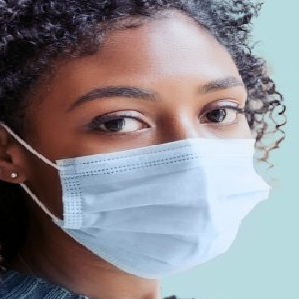

Image: bor_lin1.jpg_face_1.png - Prediction: Mask (Probabilities: [9.7495687e-01 2.6400397e-05 2.5016777e-02])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


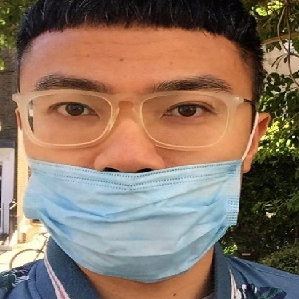

Image: bor_lin13.jpeg_face_1.png - Prediction: Wrong Mask (Probabilities: [1.7194681e-01 2.8132261e-05 8.2802510e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


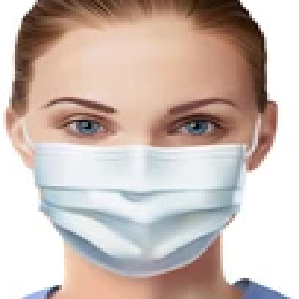

Image: test2.png_face_2.png - Prediction: Mask (Probabilities: [9.9972540e-01 1.0103093e-06 2.7359539e-04])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


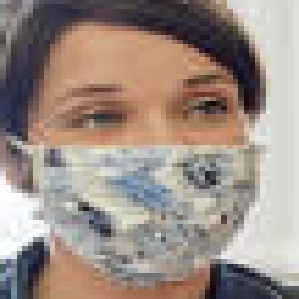

Image: gettyimages-1481643395-612x612.jpg_face_2.png - Prediction: Mask (Probabilities: [0.85610664 0.04613238 0.09776096])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


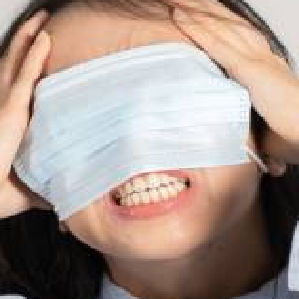

Image: gettyimages-1646342858-612x612.jpg_face_1.png - Prediction: Mask (Probabilities: [9.9843258e-01 4.9881339e-05 1.5175665e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


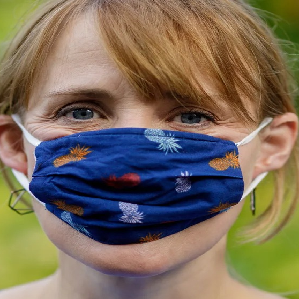

Image: bor_lin15.jpeg_face_1.png - Prediction: Wrong Mask (Probabilities: [0.01875704 0.00279524 0.97844774])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


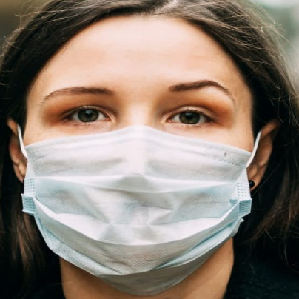

Image: bor_lin11.jpeg_face_1.png - Prediction: Mask (Probabilities: [6.8470967e-01 2.0143263e-04 3.1508893e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


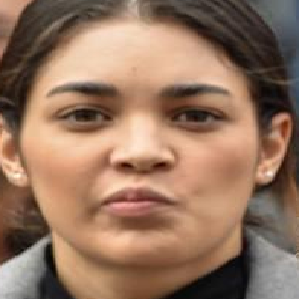

Image: mix_mask_3.jpg_face_2.png - Prediction: No Mask (Probabilities: [1.2650698e-07 9.9999297e-01 6.8989830e-06])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


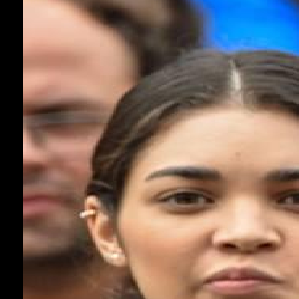

Image: mix_mask_3.jpg_face_4.png - Prediction: No Mask (Probabilities: [1.0058758e-06 9.9997365e-01 2.5395708e-05])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


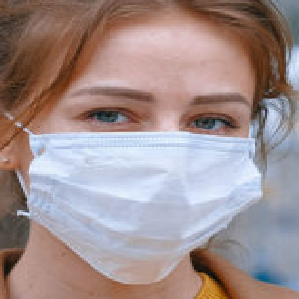

Image: bor_lin9.jpg_face_1.png - Prediction: Mask (Probabilities: [9.3037242e-01 1.6850174e-06 6.9625936e-02])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


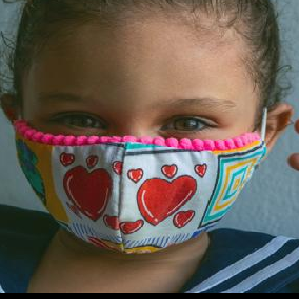

Image: bor_lin8.jpg_face_1.png - Prediction: Mask (Probabilities: [9.9797267e-01 2.5486344e-05 2.0018509e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


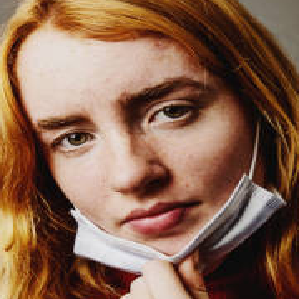

Image: gettyimages-1292019425-612x612.jpg_face_1.png - Prediction: Wrong Mask (Probabilities: [1.5472593e-05 1.9763316e-04 9.9978691e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


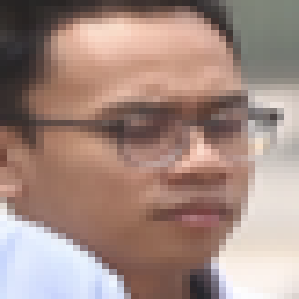

Image: mix_mask_2.png_face_2.png - Prediction: Mask (Probabilities: [0.99756753 0.00127257 0.0011599 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


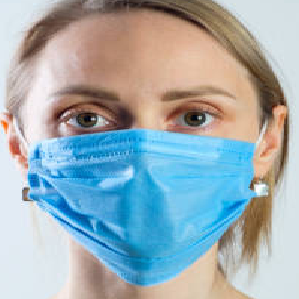

Image: gettyimages-1363608328-612x612.jpg_face_1.png - Prediction: Mask (Probabilities: [9.6785396e-01 2.4862006e-06 3.2143492e-02])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


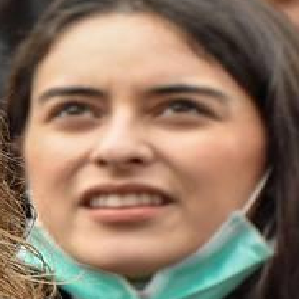

Image: mix_mask_3.jpg_face_3.png - Prediction: No Mask (Probabilities: [6.0765125e-04 7.8593147e-01 2.1346091e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


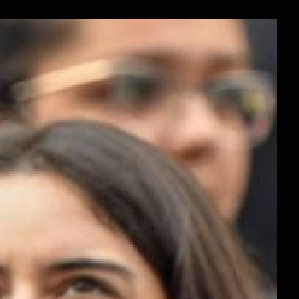

Image: mix_mask_3.jpg_face_5.png - Prediction: No Mask (Probabilities: [1.6263613e-02 9.8359829e-01 1.3808449e-04])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


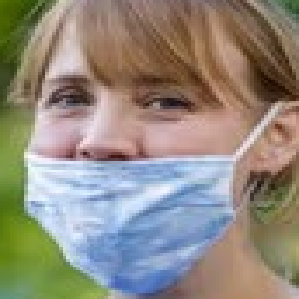

Image: bor_lin16.jpeg_face_1.png - Prediction: Wrong Mask (Probabilities: [8.1256054e-02 1.7410026e-04 9.1856986e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


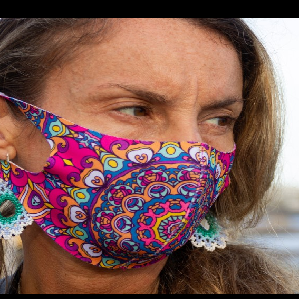

Image: bor_lin3.jpg_face_1.png - Prediction: Mask (Probabilities: [9.9799228e-01 4.8928766e-04 1.5183961e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


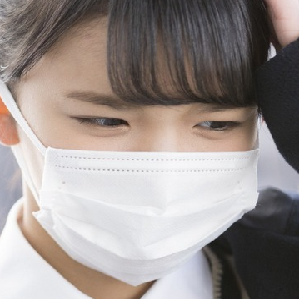

Image: bor_lin18.jpeg_face_1.png - Prediction: Mask (Probabilities: [9.975303e-01 6.985217e-06 2.462719e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


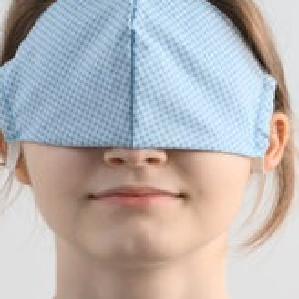

Image: bor_lin12.jpeg_face_1.png - Prediction: Mask (Probabilities: [0.7495011  0.00517553 0.24532333])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


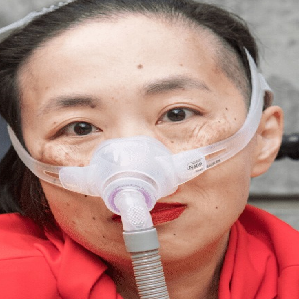

Image: bor_lin17.jpeg_face_1.png - Prediction: Mask (Probabilities: [0.9679473  0.00839006 0.0236626 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


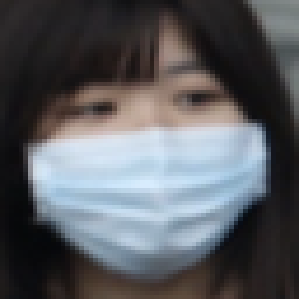

Image: w_mask_2.png_face_1.png - Prediction: Mask (Probabilities: [0.92663836 0.01183827 0.06152333])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


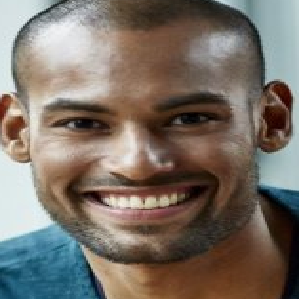

Image: test.jpg_face_1.png - Prediction: No Mask (Probabilities: [3.5687106e-06 9.9692070e-01 3.0757464e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


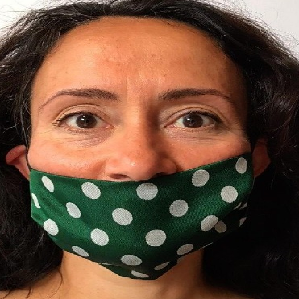

Image: bor_lin13.jpeg_face_2.png - Prediction: Mask (Probabilities: [9.4612443e-01 4.3599797e-05 5.3831868e-02])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


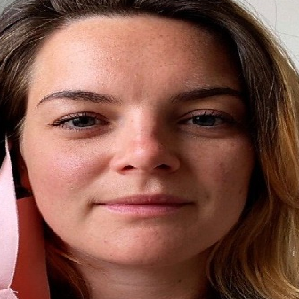

Image: bor_lin13.jpeg_face_3.png - Prediction: No Mask (Probabilities: [1.0185215e-07 9.9843651e-01 1.5633909e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


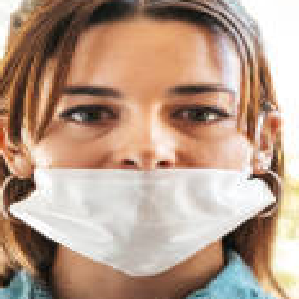

Image: gettyimages-1280412006-612x612.jpg_face_1.png - Prediction: Mask (Probabilities: [9.585299e-01 3.758774e-04 4.109415e-02])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


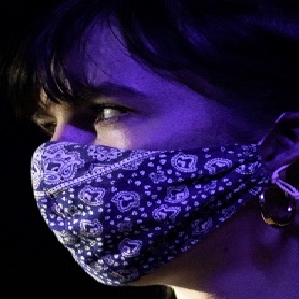

Image: bor_lin4.jpg_face_1.png - Prediction: Mask (Probabilities: [9.8594415e-01 1.3477498e-02 5.7834631e-04])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


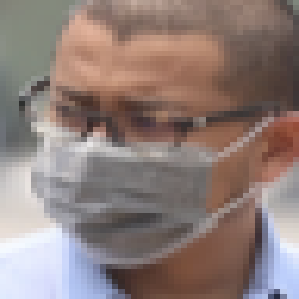

Image: mix_mask_2.png_face_1.png - Prediction: Mask (Probabilities: [0.9622211  0.00137568 0.03640321])


In [9]:
# Folder containing images to test
test_images_folder = '../dataset/images/cropped'  # Update with your folder path

class_labels = ['Mask', 'No Mask', 'Wrong Mask']  # Update class labels accordingly

for image_name in os.listdir(test_images_folder):
    image_path = os.path.join(test_images_folder, image_name)
    # Load and preprocess the image
    img = load_img(image_path, target_size=(image_size, image_size))  # Resize to match input size
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Get class index with highest probability
    label = class_labels[predicted_class]  # Map index to class label
    
    display(img)
    print(f"Image: {image_name} - Prediction: {label} (Probabilities: {prediction[0]})")
